## パッケージ導入

In [ ]:
!pip install --upgrade google-cloud-aiplatform japanize_matplotlib

In [ ]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [2]:
import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import caching

In [3]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

model_flash = GenerativeModel('gemini-1.5-flash')

In [4]:
def create_cached_model(movie_file, model_name='gemini-1.5-pro-001', ttl=60):
    prompt_cached = [
        '[movie file]',
        Part.from_uri(movie_file, mime_type='video/mp4'),
    ]
    cached_content = caching.CachedContent.create(
        model_name=model_name,
        contents=prompt_cached,
        ttl=datetime.timedelta(minutes=ttl)
    )
    model = GenerativeModel.from_cached_content(cached_content=cached_content)
    return model

In [5]:
def generate(prompt, model, temperature=0.4, top_p=0.4):
    responses = model.generate_content(
        prompt,
        generation_config={
            'max_output_tokens': 8192,
            'temperature': temperature,
            'top_p': top_p
        },
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    result = ''
    for response in responses:  # API からの応答をストリーミングで画面表示
        try:
            print(response.text, end='')
            result += response.text
        except Exception as e:
            print(e)
            break

    return result               # 応答全体を返却

In [6]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

## 対象動画をキャッシング

In [7]:
!gsutil ls -l {BUCKET}/mp4/s*

  24857097  2024-09-21T01:35:04Z  gs://your-project-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
   5514908  2024-09-21T01:39:05Z  gs://your-project-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2024-09-21T01:40:53Z  gs://your-project-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 3 objects, 61187454 bytes (58.35 MiB)


In [9]:
target_s = f'{BUCKET}/mp4/s_千葉県印西市にデータセンターを開設.mp4'
model = create_cached_model(target_s, ttl=300)

# ファイル名の先頭が n_ の無音動画ファイルを指定すること
target_n = f'{BUCKET}/mp4/n_千葉県印西市にデータセンターを開設.mp4'
model_noaudio = create_cached_model(target_n, ttl=300)

**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [10]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出

In [11]:
prompt_identify_characters = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

In [12]:
result = generate(prompt_identify_characters, model=model)

[
  {
    "Character ID": 1,
    "Name": "金井 匡彦",
    "Visual Description": "50代くらいの男性。黒髪で短髪。白いTシャツを着ており、Tシャツには青色の波と月が描かれている。Googleのデータセンターの前に立っている。",
    "Scenes": [
      "00:00-00:07",
      "00:07-00:25",
      "00:30-00:36"
    ]
  },
  {
    "Character ID": 2,
    "Name": "Unknown",
    "Visual Description": "30代くらいの女性。黒髪のお団子ヘア。白いブラウスに黒のカーディガン、ベージュのスカートを着用している。Googleのデータセンターの前に立っている。",
    "Scenes": [
      "00:36-01:25"
    ]
  },
  {
    "Character ID": 3,
    "Name": "高橋 駿",
    "Visual Description": "20代くらいの男性。髪は半分が青、半分が赤に染められている。黒のTシャツを着ており、TシャツにはGoogle Cloudのロゴが入っている。会議室のような部屋に座っている。",
    "Scenes": [
      "01:26-01:50"
    ]
  },
  {
    "Character ID": 4,
    "Name": "レオ キャラモン",
    "Visual Description": "40代くらいの男性。黒髪で短髪。黒縁メガネをかけている。黒のポロシャツを着ており、胸元に会社のロゴが入っている。回転ドアのあるエントランスホールに立っている。",
    "Scenes": [
      "01:50-02:14"
    ]
  }
]

=====
1 金井 匡彦 50代くらいの男性。黒髪で短髪。白いTシャツを着ており、Tシャツには青色の波と月が描かれている。Googleのデータセンターの前に立っている。


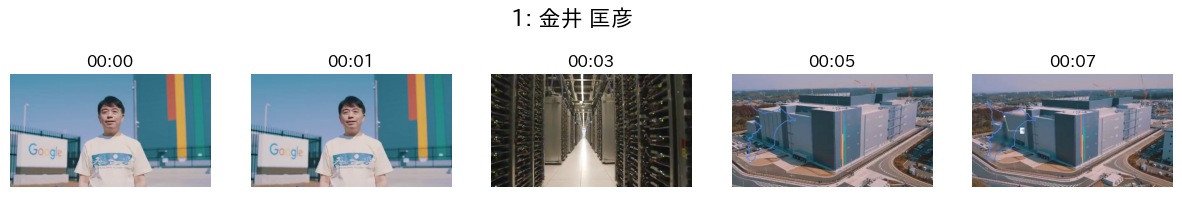

<Figure size 640x480 with 0 Axes>

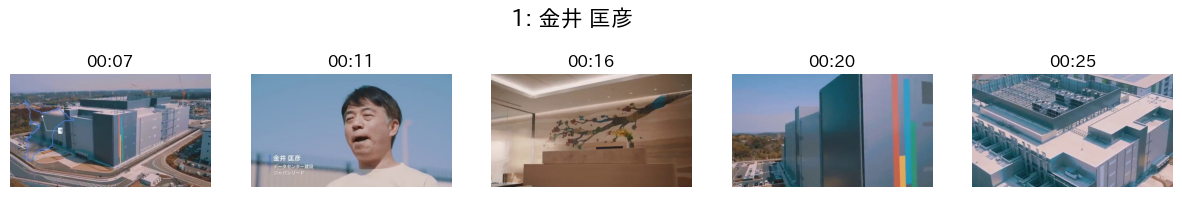

<Figure size 640x480 with 0 Axes>

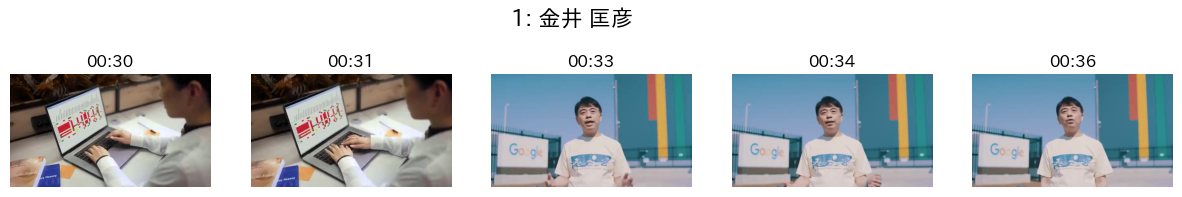

=====
2 Unknown 30代くらいの女性。黒髪のお団子ヘア。白いブラウスに黒のカーディガン、ベージュのスカートを着用している。Googleのデータセンターの前に立っている。


<Figure size 640x480 with 0 Axes>

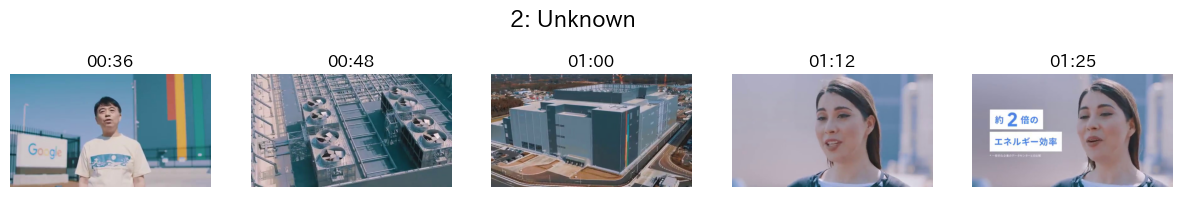

=====
3 高橋 駿 20代くらいの男性。髪は半分が青、半分が赤に染められている。黒のTシャツを着ており、TシャツにはGoogle Cloudのロゴが入っている。会議室のような部屋に座っている。


<Figure size 640x480 with 0 Axes>

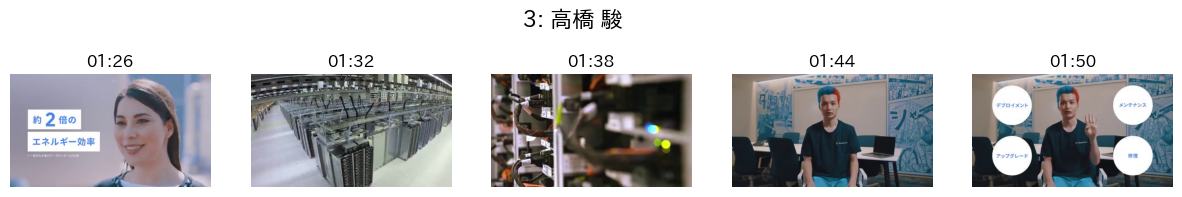

=====
4 レオ キャラモン 40代くらいの男性。黒髪で短髪。黒縁メガネをかけている。黒のポロシャツを着ており、胸元に会社のロゴが入っている。回転ドアのあるエントランスホールに立っている。


<Figure size 640x480 with 0 Axes>

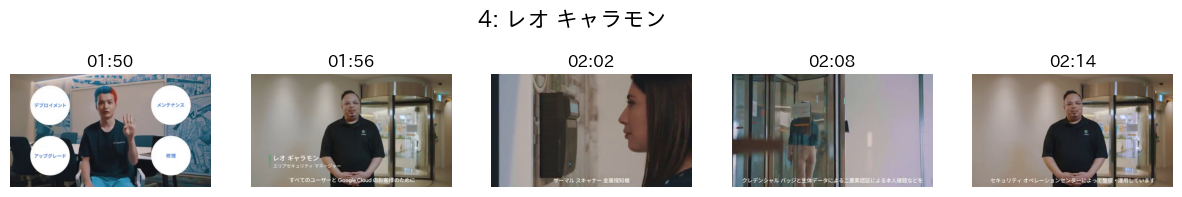

<Figure size 640x480 with 0 Axes>

In [13]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [14]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://your-project-handson/image/千葉県印西市にデータセンターを開設/characters/ルイーズ イヴァノフ.png',
 'gs://your-project-handson/image/千葉県印西市にデータセンターを開設/characters/レオ ギャラモン.png',
 'gs://your-project-handson/image/千葉県印西市にデータセンターを開設/characters/金井 匡彦.png',
 'gs://your-project-handson/image/千葉県印西市にデータセンターを開設/characters/高橋 駿.png']

In [15]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "ルイーズ イヴァノフ"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/\345\215\203\350\221\211\347\234\214\345\215\260\350\245\277\345\270\202\343\201\253\343\203\206\343\202\231\343\203\274\343\202\277\343\202\273\343\203\263\343\202\277\343\203\274\343\202\222\351\226\213\350\250\255/characters/\343\203\253\343\202\244\343\203\274\343\202\271\343\202\231 \343\202\244\343\202\246\343\202\231\343\202\241\343\203\216\343\203\225.png"
 },
 'The name of following character is "レオ ギャラモン"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://your-project-handson/image/\345\215\203\350\221\211\347\234\214\345\215\260\350\245\277\345\270\202\343\201\253\343\203\206\343\202\231\343\203\274\343\202\277\343\202\273\343\203\263\343\202\277\343\203\274\343\202\222\351\226\213\350\250\255/characters/\343\203\254\343\202\252 \343\202\255\343\202\231\343\203\243\343\20

## 動画サマリー

In [16]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
In Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

prompt_summary = [prompt_summary] + prompt_reference

In [17]:
result = generate(prompt_summary, model=model)

{
  "Title": "千葉県印西市に開設された Google 最大規模のデータセンター",
  "Summary": "2023年、Google は千葉県印西市に日本最大規模のハイパースケールデータセンターを開設しました。\nデータセンター建設の責任者である金井匡彦氏によると、このデータセンターは Google データセンターのグローバル設計基準と日本の技術・文化を融合させて設計されており、環境にも配慮しています。\nこのデータセンターにより、日本の企業は Google Cloud を含む Google 製品をより快適かつ安全に利用できるようになります。\nビルディングプログラムマネージャーのルイーズ・イヴァノフ氏によると、データセンターでは重要なインフラの運用・維持を24時間365日行っています。\n高いパフォーマンスを維持するために、電力や冷却システムの継続的な供給が必要不可欠であり、地域の環境や気候に沿った Google 基準のメンテナンスを実施することで、世界の Google データセンターと同レベルの信頼性を実現しています。\nまた、インフラを効率的に運用していることも特徴の一つであり、一般的な企業のデータセンターと比較して約2倍のエネルギー効率を誇ります。\nデータセンター技術者の高橋駿氏によると、ハードウェア運用チームは何百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現しています。\nサーバーは無駄を省くために必要なコンポーネントのみを使用し、顧客にコストパフォーマンスの良いサービスを提供しています。\nまた、すべてのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行っています。\nエリアセキュリティマネージャーのレオ・ギャラモン氏によると、すべてのユーザーと Google Cloud のお客様のために、データセンターを安全に保護するために、サーマルスキャナー、金属探知機、クレデンシャルバッジと生体認証データによる二要素認証など、6層のセキュリティを導入しています。\nこれは、24時間体制のガードフォースとセキュリティオペレーションセンターによって管理・運用されています。\nアクセスの高速化と強固なセキュリティによる安定性と安全性、加えてサステナビリティへの配慮で、持続可能な経済活動を支えてい

In [18]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [19]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

prompt_important_scenes = [prompt_important_scenes] + prompt_reference

In [20]:
important_scenes = generate(prompt_important_scenes, model=model)

Timestamp, Description
00:00-00:07, Google データセンター建設の責任者である金井匡彦氏が、2023年に千葉県印西市にデータセンターを開設したことを発表する重要なシーンです。
00:07-00:25, 金井匡彦氏が、データセンターの特徴として、Google データセンターのグローバル設計基準と日本の技術・文化を融合させて設計されていること、環境にも配慮していること、日本最大規模のハイパースケールデータセンターであることを説明する重要なシーンです。
00:25-01:25, ビルディングプログラムマネージャーのルイーズ・イヴァノフ氏が、データセンターの運用・維持、信頼性、エネルギー効率について説明する重要なシーンです。
01:25-01:50, データセンター技術者の高橋駿氏が、ハードウェア運用チームの役割、サーバーの設計、顧客へのサービス提供について説明する重要なシーンです。
01:50-02:14, エリアセキュリティマネージャーのレオ・ギャラモン氏が、データセンターのセキュリティ対策について説明する重要なシーンです。
02:14-02:35, データセンターの安定性と安全性、サステナビリティへの配慮、日本の顧客のビジネスとグローバルなデジタルエコノミーとの架け橋としての役割についてまとめる重要なシーンです。

## シーン情報（ビジュアル情報）取得

In [21]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

prompt_visuals = [prompt_visuals] + prompt_reference

In [22]:
visual_info = generate(prompt_visuals, model=model)

Timestamp, Description
00:00-00:01, 金井 匡彦さんがGoogleの看板の前で話しています。金井 匡彦さんは白いTシャツを着ており、背景にはGoogleのデータセンターが見えます。晴天で、空は青く澄み渡っています。
00:01-00:03, データセンターの内部の映像です。サーバーがずらりと並んでおり、通路の奥には光が見えます。通路の床は白く、天井には蛍光灯が設置されています。
00:03-00:06, 千葉県印西市に建設されたGoogleのデータセンターの外観です。データセンターは、グレーの壁で覆われており、正面にはGoogleのロゴカラーである赤、黄、緑、青のラインが入っています。周囲には緑豊かな木々が広がっています。
00:06-00:08, Googleのデータセンターの前で金井 匡彦さんが話しています。金井 匡彦さんは白いTシャツを着ており、背景にはGoogleのデータセンターが見えます。晴天で、空は青く澄み渡っています。
00:08-00:11, Googleのデータセンターの入り口で、男性が建物に入ろうとしています。男性は黒いリュックサックを背負っており、白い建物にはGoogleのロゴが大きく描かれています。建物の周囲には、緑の木々が生い茂っています。
00:11-00:14, Googleのデータセンターの受付です。受付カウンターは木目調で、壁には木の枝と花が描かれたアートが飾られています。カウンターの上には黄色い花が活けられており、奥にはガラス張りの部屋が見えます。
00:14-00:18, Googleのデータセンターの外観です。データセンターは、グレーの壁で覆われており、正面にはGoogleのロゴカラーである赤、黄、緑、青のラインが入っています。周囲には緑豊かな木々が広がっています。
00:18-00:22, Googleのデータセンターの屋上です。屋上には、空調設備や配管などが設置されています。データセンターの壁はグレーで、周囲には緑豊かな木々が広がっています。
00:22-00:26, 東京の街並みを夕日が照らしています。高層ビルが立ち並び、遠くには東京タワーが見えます。空はオレンジ色に染まり、雲が浮かんでいます。
00:26-00:29, 女性がオフィスでプレゼンテーションを行っています。女性は白いブラウ

## 音声文字起こし

In [23]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

In [24]:
result = generate([prompt_transcription] + prompt_reference, model=model)

```json
[
  {
    "timestamp": "00:00-00:07",
    "Name": "金井 匡彦",
    "Transcription": "2023年 Googleとして データセンターを ここ 千葉県印西市に開設しました"
  },
  {
    "timestamp": "00:07-00:25",
    "Name": "金井 匡彦",
    "Transcription": "このデータセンターの特徴は 何と言ってもGoogleデータセンターのグローバル設計基準と 日本技術 文化の融合にて設計されていること そして日本で最大規模のハイパースケールデータセンターであることです 当然環境にも配慮した設計になっています このデータセンターによって日本の企業の皆様が Google Cloudを含むGoogle製品を さらに快適に そして安全にお使いいただけるようになります"
  },
  {
    "timestamp": "00:37-01:25",
    "Name": "ルイーズ イヴァノフ",
    "Transcription": "データセンターでは 重要なインフラの運用維持を 24時間365日行っています 高いパフォーマンスを維持するために 電力や冷却システムの継続的な供給が必要不可欠です 地域の慣行や気候に沿ったGoogle基準のメンテナンスを実行することで 世界のGoogleデータセンターと同レベルの信頼性を実現しています また インフラを効率的に運用していることも このデータセンターの大きな特徴の1つです 全てのオペレーションが 環境に与える影響を最小限に抑える つまり より少ないエネルギーでの運用に 注力することで 一般的な企業のデータセンターと比較して 約2倍のエネルギー効率を誇ります"
  },
  {
    "timestamp": "01:27-01:50",
    "Name": "高橋 駿",
    "Transcription": "ハードウェア運用チームは 何百万ものリクエストをデータセンター内で実行し 高品質なパフォーマンスを実現しています サーバーは 無駄を省くために 必要なコンポーネントのみを使用し お客様に コストパフォーマンスの良いサービスを提供しています ま

In [25]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

１回の処理ですべてのテキストを取得しようとすると、出力トークン数の上限に達するので、はじめにテキストが存在するシーンの情報を取得する。

In [26]:
prompt_text_layout = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Identify scenes where text strings are on the screen.
B. Describe the layout how text strings are arranged on the screen.

[conditions]
Process the entire movie from start to the exact end of the movie file.

[format instruction]
Layout description is in Japanese.
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Layout": "<layout description from Task B>"
}
'''

In [27]:
result = generate(prompt_text_layout, model=model_noaudio)

[
  {
    "Timestamp": "00:06-00:08",
    "Layout": "画面左側に地図が表示され、地図の中にテキストが表示されている"
  },
  {
    "Timestamp": "00:08-00:10",
    "Layout": "画面左側に縦書きで二行のテキストが表示されている"
  },
  {
    "Timestamp": "00:20-00:21",
    "Layout": "画面左下にテキストが表示されている"
  },
  {
    "Timestamp": "00:40-00:43",
    "Layout": "画面右側に円の中にテキストが表示され、円の右側に矢印が表示されている"
  },
  {
    "Timestamp": "00:41-00:43",
    "Layout": "画面左側に縦書きで三行のテキストが表示されている"
  },
  {
    "Timestamp": "01:22-01:24",
    "Layout": "画面左側に四角の中にテキストが表示され、その右側に二行のテキストが表示されている"
  },
  {
    "Timestamp": "01:27-01:29",
    "Layout": "画面左側に縦書きで二行のテキストが表示されている"
  },
  {
    "Timestamp": "01:44-01:49",
    "Layout": "画面中央に男性が表示され、男性の周りに円の中にテキストが表示されている"
  },
  {
    "Timestamp": "01:51-01:54",
    "Layout": "画面左側に縦書きで二行のテキストが表示され、その下にテキストが表示されている"
  },
  {
    "Timestamp": "01:55-01:59",
    "Layout": "画面下にテキストが表示されている"
  },
  {
    "Timestamp": "01:59-02:02",
    "Layout": "画面下にテキストが表示されている"
  },
  {
    "Timestamp": "02:03-02:07",
    "Layout": "画面下にテキストが表示

In [28]:
layout_info = load_json(result)

取得した情報から５シーンごとに分割してテキストを抽出する。

In [32]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. The [text layout] contains scenes where text strings are on the screen in JSON list.
Extract exact text strings from each scene by repeating the [steps].

[steps]
1. Take the next "text dict" item from the [text layout].
2. Extract text strings from the scene specified by the "Timestamp" and "Layout".
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. Process the scenes only within the timestamps described in the [text layout]. Hence the "Timestamp" in the output should be the same as in the [text layout].
A. Output each character literally as on the screen. Don't modify them.
A. Use a list to store multiple lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

In [33]:
merged_result = []
for c in range(0, len(layout_info), 5):
    print(f'\n=== Scene {c+1} to {c+5} ===')
    prompt = prompt_texts + pprint.pformat(layout_info[c:c+5])
    # 正しい JSON が出力されないなどで処理エラーが発生した場合は3回リトライする。
    n = 0
    while n < 3:
        try:
            result = generate(prompt, model=model_noaudio)    
            merged_result += load_json(result)
            break
        except Exception as e:
            print(e)
            n += 1
            pass
texts = pprint.pformat(merged_result)


=== Scene 1 to 5 ===
```json
[
  {
    "Timestamp": "00:06-00:08",
    "Text": [
      "千葉県 印西市"
    ],
    "Layout": "画面左側に地図が表示され、地図の中にテキストが表示されている"
  },
  {
    "Timestamp": "00:08-00:10",
    "Text": [
      "金井 匡彦",
      "データセンター建設",
      "ジャパンリード"
    ],
    "Layout": "画面左側に縦書きで二行のテキストが表示されている"
  },
  {
    "Timestamp": "00:20-00:21",
    "Text": [
      "※ハイパースケール データセンターとは、大規模なデータとクラウドコンピューティングを支える巨大でパワフルなデータセンターです。"
    ],
    "Layout": "画面左下にテキストが表示されている"
  },
  {
    "Timestamp": "00:40-00:43",
    "Text": [
      "24H",
      "365DAY"
    ],
    "Layout": "画面右側に円の中にテキストが表示され、円の右側に矢印が表示されている"
  },
  {
    "Timestamp": "00:41-00:43",
    "Text": [
      "ルイス イグアシフ",
      "ビルディングプログラムマネージャー"
    ],
    "Layout": "画面左側に縦書きで三行のテキストが表示されている"
  }
]
```
=== Scene 6 to 10 ===
```json
[
  {
    "Timestamp": "01:22-01:24",
    "Text": [
      "約2倍の",
      "エネルギー効率",
      "※一般的な企業のデータセンターとの比較"
    ],
    "Layout": "画面左側に四角の中にテキストが表示され、その右側に二行のテキストが表示されている"
  },
  {
    "Timestamp

## テキストベースの動画内検索

In [34]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

In [35]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        # 報告されたタイムスタンプの前後 3 秒を含めて 5 枚の静止画像を表示する
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [36]:
%%time
query = 'サーバーのメンテナンスについて解説しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:37-01:25",
    "Description": "このシーンでは、ルイーズ・イヴァノフ氏がデータセンターの運用・維持について説明しており、特に「地域の慣行や気候に沿ったGoogle基準のメンテナンスを実行することで、世界のGoogleデータセンターと同レベルの信頼性を実現しています」という発言から、サーバーのメンテナンスについて言及していることがわかります。",
    "Evidence": [
      "{'Name': 'ルイーズ イヴァノフ', 'Transcription': 'データセンターでは 重要なインフラの運用維持を 24時間365日行っています 高いパフォーマンスを維持するために 電力や冷却システムの継続的な供給が必要不可欠です 地域の慣行や気候に沿ったGoogle基準のメンテナンスを実行することで 世界のGoogleデータセンターと同レベルの信頼性を実現しています また インフラを効率的に運用していることも このデータセンターの大きな特徴の1つです 全てのオペレーションが 環境に与える影響を最小限に抑える つまり より少ないエネルギーでの運用に 注力することで 一般的な企業のデータセンターと比較して 約2倍のエネルギー効率を誇ります', 'timestamp': '00:37-01:25'}"
    ]
  }
]
```CPU times: user 38.2 ms, sys: 24.7 ms, total: 62.9 ms
Wall time: 1.57 s


=====
このシーンでは、ルイーズ・イヴァノフ氏がデータセンターの運用・維持について説明しており、特に「地域の慣行や気候に沿ったGoogle基準のメンテナンスを実行することで、世界のGoogleデータセンターと同レベルの信頼性を実現しています」という発言から、サーバーのメンテナンスについて言及していることがわかります。


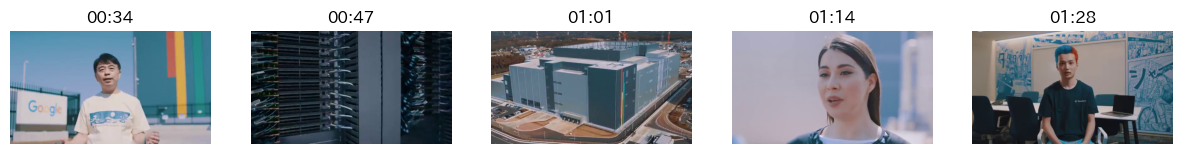

<Figure size 640x480 with 0 Axes>

In [37]:
show_thumbnails(load_json(result))

In [38]:
%%time
query = '金井さんが登場するシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:00-00:07",
    "Description": "このシーンでは、金井匡彦さんがGoogleのデータセンター開設について発表しています。",
    "Evidence": [
      {
        "Name": "金井 匡彦",
        "Transcription": "2023年 Googleとして データセンターを ここ 千葉県印西市に開設しました",
        "timestamp": "00:00-00:07"
      },
      {
        "Layout": "画面左側に地図が表示され、地図の中にテキストが表示されている",
        "Text": [
          "千葉県 印西市"
        ],
        "Timestamp": "00:06-00:08"
      }
    ]
  },
  {
    "Timestamp": "00:07-00:25",
    "Description": "このシーンでは、金井匡彦さんがデータセンターの特徴について説明しており、その中で「日本で最大規模のハイパースケールデータセンターであること」を述べています。",
    "Evidence": [
      {
        "Name": "金井 匡彦",
        "Transcription": "このデータセンターの特徴は 何と言ってもGoogleデータセンターのグローバル設計基準と 日本技術 文化の融合にて設計されていること そして日本で最大規模のハイパースケールデータセンターであることです 当然環境にも配慮した設計になっています このデータセンターによって日本の企業の皆様が Google Cloudを含むGoogle製品を さらに快適に そして安全にお使いいただけるようになります",
        "timestamp": "00:07-00:25"
      },
      {
        "Layout": "画面左下にテキストが表示されている",
        "Text": [
          "※ハイパースケール データセンターとは、大規模なデー

=====
このシーンでは、金井匡彦さんがGoogleのデータセンター開設について発表しています。


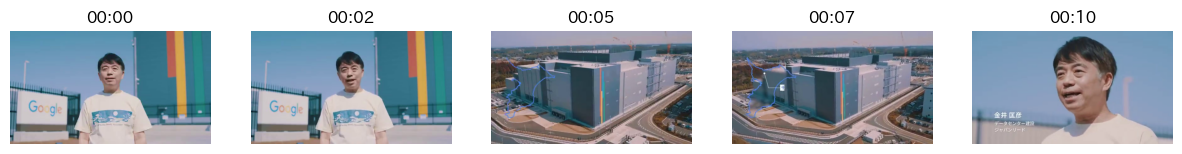

=====
このシーンでは、金井匡彦さんがデータセンターの特徴について説明しており、その中で「日本で最大規模のハイパースケールデータセンターであること」を述べています。


<Figure size 640x480 with 0 Axes>

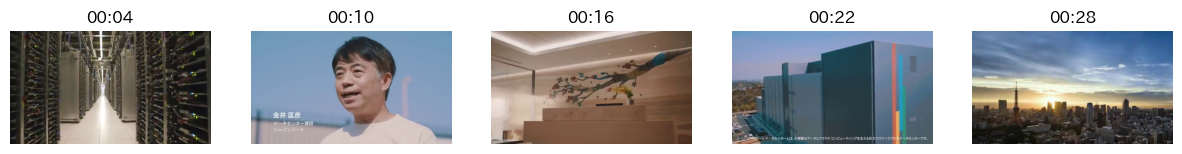

<Figure size 640x480 with 0 Axes>

In [39]:
show_thumbnails(load_json(result))

In [40]:
%%time
query = 'SNS投稿に適した映えるシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:00-00:07",
    "Description": "このシーンは、Googleのデータセンター建設責任者である金井匡彦氏が、2023年に千葉県印西市にデータセンターを開設したことを発表するシーンです。データセンターの外観や、金井匡彦氏の表情が映し出されており、SNS投稿に適した映えるシーンと言えるでしょう。",
    "Evidence": [
      "{'Name': '金井 匡彦', 'Transcription': '2023年 Googleとして データセンターを ここ 千葉県印西市に開設しました', 'timestamp': '00:00-00:07'}",
      "{'Layout': '画面左側に地図が表示され、地図の中にテキストが表示されている', 'Text': ['千葉県 印西市'], 'Timestamp': '00:06-00:08'}"
    ]
  },
  {
    "Timestamp": "00:03-00:06",
    "Description": "このシーンは、千葉県印西市に建設されたGoogleのデータセンターの外観が映し出されています。データセンターは、グレーの壁で覆われており、正面にはGoogleのロゴカラーである赤、黄、緑、青のラインが入っています。周囲には緑豊かな木々が広がっています。データセンターの壮大さと自然との調和が美しく、SNS投稿に適した映えるシーンと言えるでしょう。",
    "Evidence": [
      "{'Layout': '画面左側に地図が表示され、地図の中にテキストが表示されている', 'Text': ['千葉県 印西市'], 'Timestamp': '00:06-00:08'}",
      "00:03-00:06, 千葉県印西市に建設されたGoogleのデータセンターの外観です。データセンターは、グレーの壁で覆われており、正面にはGoogleのロゴカラーである赤、黄、緑、青のラインが入っています。周囲には緑豊かな木々が広がっています。"
    ]
  },
  {
    "Timestamp": "00:25-01:25",
    "Description": "この

=====
このシーンは、Googleのデータセンター建設責任者である金井匡彦氏が、2023年に千葉県印西市にデータセンターを開設したことを発表するシーンです。データセンターの外観や、金井匡彦氏の表情が映し出されており、SNS投稿に適した映えるシーンと言えるでしょう。


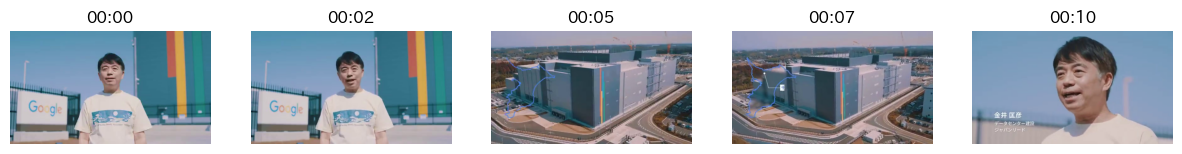

=====
このシーンは、千葉県印西市に建設されたGoogleのデータセンターの外観が映し出されています。データセンターは、グレーの壁で覆われており、正面にはGoogleのロゴカラーである赤、黄、緑、青のラインが入っています。周囲には緑豊かな木々が広がっています。データセンターの壮大さと自然との調和が美しく、SNS投稿に適した映えるシーンと言えるでしょう。


<Figure size 640x480 with 0 Axes>

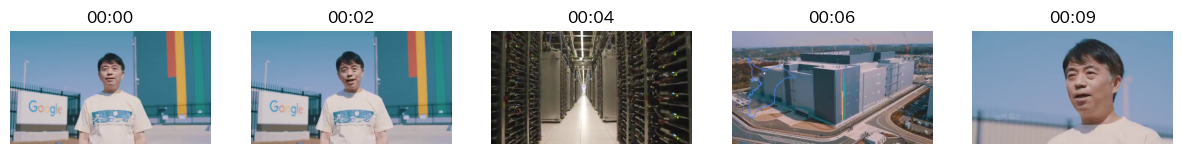

=====
このシーンは、ビルディングプログラムマネージャーのルイーズ・イヴァノフ氏が、データセンターの運用・維持、信頼性、エネルギー効率について説明するシーンです。データセンター内部のサーバー群や、冷却システムなどが映し出されており、データセンターの規模感と先進的な技術が伝わってくるため、SNS投稿に適した映えるシーンと言えるでしょう。


<Figure size 640x480 with 0 Axes>

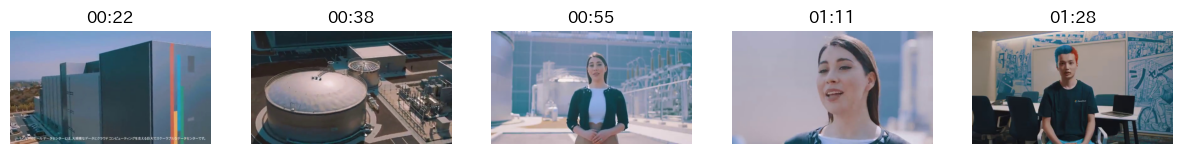

<Figure size 640x480 with 0 Axes>

In [41]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [45]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

In [46]:
%%time
query = 'サーバーのメンテナンスについて解説しているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "00:37-01:25",
    "Description": "ルイーズ イヴァノフさんが、データセンターにおけるインフラの運用維持について解説しています。高いパフォーマンスを維持するために必要な電力や冷却システムの継続的な供給の重要性、Google基準のメンテナンスの実施、エネルギー効率の高さについて説明しています。"
  },
  {
    "Timestamp": "01:26-01:49",
    "Description": "高橋 駿さんが、データセンター内のハードウェア運用チームの役割について解説しています。数百万ものリグレッションテストの実施、高品質なパフォーマンスの実現、無駄を省いたサーバー設計、顧客へのコストパフォーマンスの良いサービス提供について説明しています。"
  }
]CPU times: user 74.1 ms, sys: 7.16 ms, total: 81.3 ms
Wall time: 17.5 s


=====
ルイーズ イヴァノフさんが、データセンターにおけるインフラの運用維持について解説しています。高いパフォーマンスを維持するために必要な電力や冷却システムの継続的な供給の重要性、Google基準のメンテナンスの実施、エネルギー効率の高さについて説明しています。


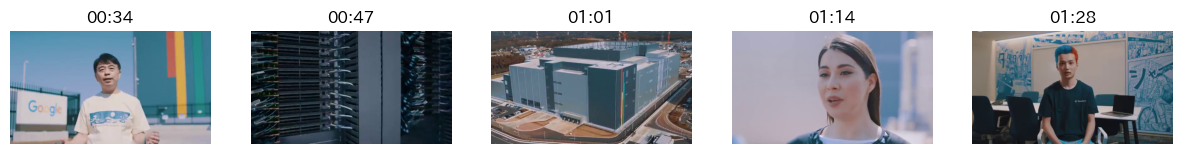

=====
高橋 駿さんが、データセンター内のハードウェア運用チームの役割について解説しています。数百万ものリグレッションテストの実施、高品質なパフォーマンスの実現、無駄を省いたサーバー設計、顧客へのコストパフォーマンスの良いサービス提供について説明しています。


<Figure size 640x480 with 0 Axes>

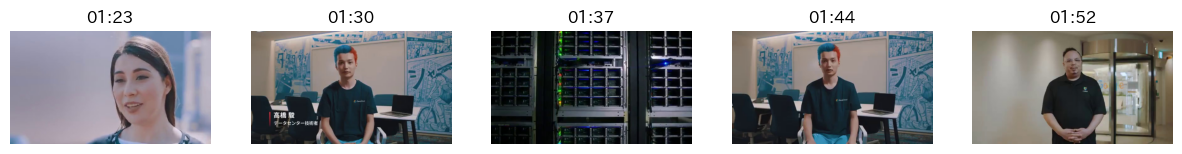

<Figure size 640x480 with 0 Axes>

In [47]:
show_thumbnails(load_json(result))

In [48]:
%%time
query = '金井さんが登場するシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

```json
[
  {
    "Timestamp": "00:00-00:08",
    "Description": "金井さんがGoogleのデータセンターについて説明しているシーンです。"
  },
  {
    "Timestamp": "00:08-00:25",
    "Description": "金井さんがデータセンターの特徴について説明しているシーンです。"
  },
  {
    "Timestamp": "02:21-02:35",
    "Description": "金井さんがデータセンターの役割について説明しているシーンです。"
  }
]
```CPU times: user 71.9 ms, sys: 16.3 ms, total: 88.2 ms
Wall time: 16.4 s


=====
金井さんがGoogleのデータセンターについて説明しているシーンです。


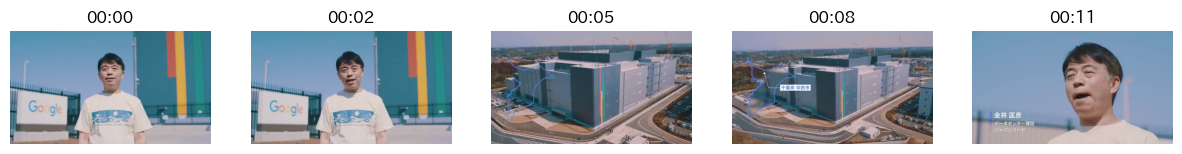

=====
金井さんがデータセンターの特徴について説明しているシーンです。


<Figure size 640x480 with 0 Axes>

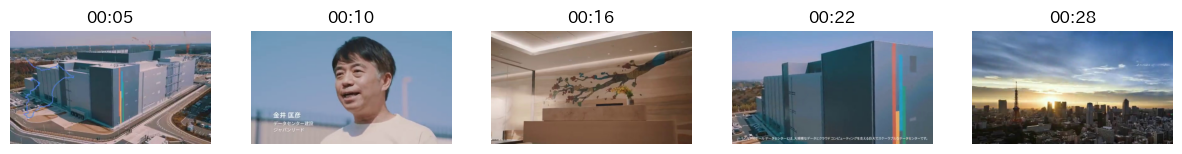

=====
金井さんがデータセンターの役割について説明しているシーンです。


<Figure size 640x480 with 0 Axes>

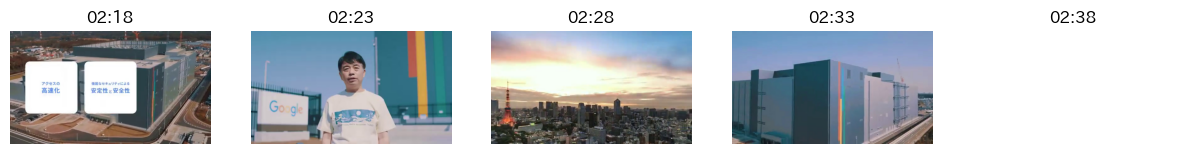

<Figure size 640x480 with 0 Axes>

In [49]:
show_thumbnails(load_json(result))

In [50]:
%%time
query = 'SNS投稿に適した映えるシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "00:00-00:07",
    "Description": "Google データセンターの外観を空撮した映像は、スケールの大きさを感じさせ、SNS映えするシーンです。特に、建物の側面に描かれたGoogleカラーのラインが印象的です。"
  },
  {
    "Timestamp": "00:25-00:36",
    "Description": "データセンターの屋上にある冷却装置を空撮した映像は、近未来的な雰囲気があり、SNS映えするシーンです。冷却装置の規則的な配置と、背景の青空とのコントラストが美しいです。"
  },
  {
    "Timestamp": "01:39-01:42",
    "Description": "データセンター内部のサーバーが並ぶ通路を捉えた映像は、SF映画のような世界観を表現しており、SNS映えするシーンです。サーバーの青い光と、奥行きのある通路が神秘的な印象を与えます。"
  }
]CPU times: user 69 ms, sys: 15.8 ms, total: 84.9 ms
Wall time: 18.2 s


=====
Google データセンターの外観を空撮した映像は、スケールの大きさを感じさせ、SNS映えするシーンです。特に、建物の側面に描かれたGoogleカラーのラインが印象的です。


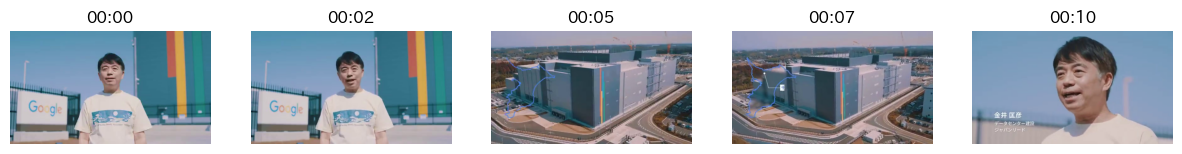

=====
データセンターの屋上にある冷却装置を空撮した映像は、近未来的な雰囲気があり、SNS映えするシーンです。冷却装置の規則的な配置と、背景の青空とのコントラストが美しいです。


<Figure size 640x480 with 0 Axes>

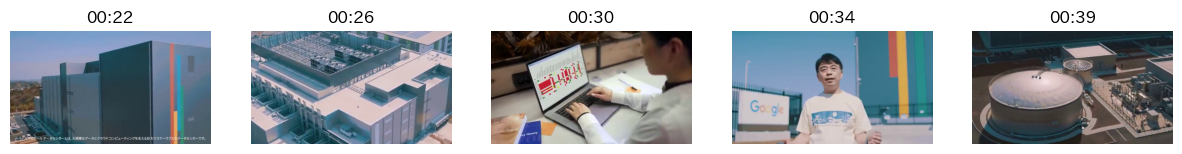

=====
データセンター内部のサーバーが並ぶ通路を捉えた映像は、SF映画のような世界観を表現しており、SNS映えするシーンです。サーバーの青い光と、奥行きのある通路が神秘的な印象を与えます。


<Figure size 640x480 with 0 Axes>

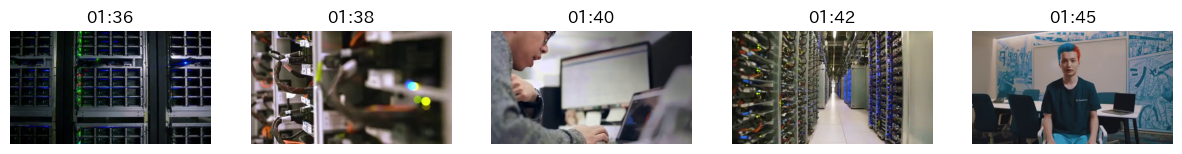

<Figure size 640x480 with 0 Axes>

In [51]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [52]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [53]:
!gsutil cp "{metafile}" {BUCKET}/metadata/

I0000 00:00:1726892446.626105    5595 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


Copying file://千葉県印西市にデータセンターを開設.txt [Content-Type=text/plain]...
/ [1 files][ 20.7 KiB/ 20.7 KiB]                                                
Operation completed over 1 objects/20.7 KiB.                                     
